# Подготовка

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
import pandahouse
%matplotlib inline

In [10]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220820',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-07-06' and '2022-07-12'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

# Смотрим на данные

In [11]:
# Посмотрим сколько у нас пользователей в группах
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


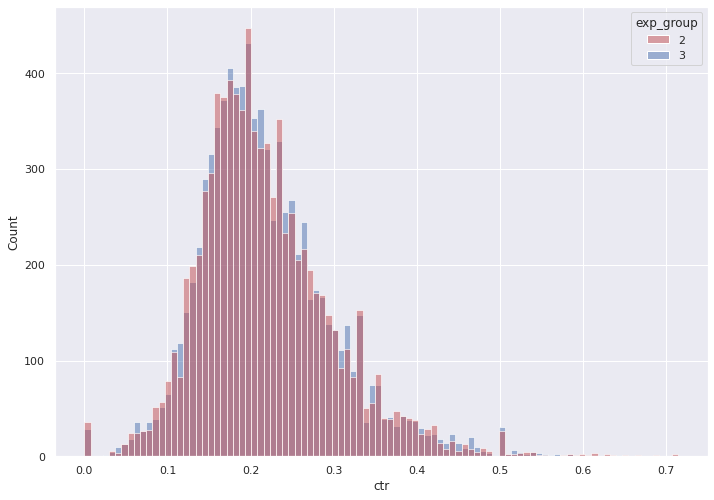

In [12]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Построим гистограммы распределения групп
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

# A/A-тестирование

In [15]:
# функция симуляции проведения A/A-тестов, возвращает Series из p-value "проведенных" тестов
def AA_test_simulation(ctr1, ctr2, n_simulation=10000):
    p_values = []

    for _ in range(n_simulation):
        p_values.append(stats.ttest_ind(ctr1.sample(500),
                    ctr2.sample(500),
                    equal_var=False)[1])
        
    return pd.Series(p_values)

In [16]:
# получаем p-values
p_values = AA_test_simulation(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr)
p_values[:10]

0    0.663770
1    0.647854
2    0.208908
3    0.533428
4    0.848089
5    0.606974
6    0.325001
7    0.638675
8    0.084037
9    0.316408
dtype: float64

<AxesSubplot:ylabel='Count'>

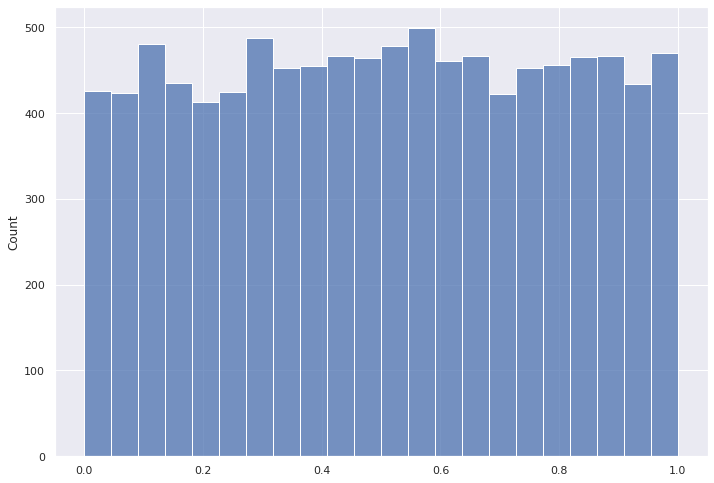

In [17]:
# строим гистограмму распределения получившихся p-values
sns.histplot(p_values)

In [19]:
# считаем какой процент p-values оказался меньше либо равен 0.05
len(p_values.where(p_values <= 0.05).dropna()) / len(p_values) * 100

4.68

# Вывод

Система сплитования работает корректно, так как на симуляции 10000 A/A-тестов, p-value меньше 0.05 встречается в чуть меньше чем 5% случаев. Это означает, что с вероятностью примерно 95% наша система сплитования работает корректно.